In [ ]:
### Pythonのバージョン確認
import sys
print(sys.version)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [ ]:
import matplotlib.pyplot as plt
import math
import random

# フィールドの初期化

In [ ]:
### 壁の座標 (x, y) を保持する配列
wall_xs = []
wall_ys = []

max_x = 50 # [m]
max_y = 50 # [m]

### 下壁
for i in range(0, max_x):
    wall_xs.append(i)
    wall_ys.append(0)

### 上壁
for i in range(0, max_x):
    wall_xs.append(i)
    wall_ys.append(max_y - 1)

### 左壁
for i in range(0, max_y):
    wall_xs.append(0)
    wall_ys.append(i)

### 右壁
for i in range(0, max_y):
    wall_xs.append(max_x - 1)
    wall_ys.append(i)

print('wall_xs =', wall_xs)
print('wall_ys =', wall_ys)

wall_xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49]
wall_ys = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49

In [ ]:
### 円形障害物の位置と半径 (x, y, r) を保持する配列
# ([m], [m], [m])
obs_circles = [
    (15, 35, 3),
    (20, 30, 5),
    (25, 25, 5),
    (30, 20, 5)
]

In [ ]:
### スタート位置とゴール位置の座標 (x, y) を保持する変数
start_x, start_y = 10, 10 # [m]
goal_x, goal_y = 40, 40 # [m]

In [ ]:
### 円形障害物を描画する関数
def DrawObsCircles(obs_circles):
    ### matplotlibで円を描画するにはAxesが必要なのでplt.subplots()を使う
    ### 注意 : plt.subplot() ではなく plt.subplot"s"()
    ### 参考 : https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
    fig, ax = plt.subplots()
    for obs_circle_x, obs_circle_y, obs_circle_r in obs_circles:
        circle = plt.Circle((obs_circle_x, obs_circle_y), obs_circle_r, color='black')
        ax.add_artist(circle)

    return



### フィールドを描画する関数
def DrawField(wall_xs, wall_ys, start_x, start_y, goal_x, goal_y):
    plt.scatter(wall_xs, wall_ys, marker='.', color='black')
    plt.scatter(start_x, start_y, marker='x', color='blue')
    plt.scatter(goal_x, goal_y, marker='x', color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.grid(True)

    return

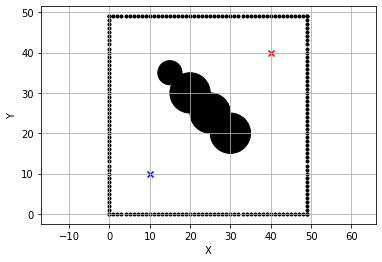

In [ ]:
DrawObsCircles(obs_circles)
DrawField(wall_xs, wall_ys, start_x, start_y, goal_x, goal_y)

# 経路探索アルゴリズムに使うデータ構造や関数の準備

In [ ]:
class Node:
    def __init__(self, x, y):
        self.x = x # [m]
        self.y = y # [m]
        self.path_xs = []
        self.path_ys = []
        self.parent_node = None
        
        ### ここがRRTとRRT*の違い 
        self.cost = 0.0

    ### クラスのインスタンス同士が等しいかどうか "Node() == Node()" で比較できるようにする
    ### 参考 : https://stackoverflow.com/questions/1227121/compare-object-instances-for-equality-by-their-attributes
    def __eq__(self, other): 
        if not isinstance(other, Node):
            return NotImplemented

        is_equal = math.isclose(self.x, other.x)
        is_equal = is_equal and math.isclose(self.y, other.y)
        is_equal = is_equal and (len(self.path_xs) == len(other.path_xs))
        is_equal = is_equal and (len(self.path_ys) == len(other.path_ys))
        is_equal = is_equal and math.isclose(self.cost, other.cost)

        return is_equal

In [ ]:
test_node_list = [
    Node(0.0, 0.0),
    Node(1.1, 1.1),
    Node(2.2, 2.2),
    Node(3.3, 3.3)
]

print('test_node_list = ', test_node_list)
print()

### "Node() == Node()" がちゃんと動くか画面に表示して動作確認
search_node = Node(2.2, 2.2)
for idx, test_node in enumerate(test_node_list):
    if test_node == search_node:
        print('idx =', idx)

test_node_list =  [<__main__.Node object at 0x7f52f3992d30>, <__main__.Node object at 0x7f52f3992d68>, <__main__.Node object at 0x7f52f3992da0>, <__main__.Node object at 0x7f52f3992dd8>]

idx = 2


In [ ]:
### ノードリストの中でランダムノードに最も近いノードを探して返す関数
### ユークリッド距離 [m] でも二乗距離 [m^2] でも大小関係は変わらないので,
### 計算時間削減のためわざわざルートを取らず二乗距離のまま大小比較している
def FindNearestNode(nodes, rand_node):
    nearest_square_dist = sys.float_info.max # [m^2]
    nearest_node = None

    for node in nodes:
        square_dist = (rand_node.x - node.x)**2 + (rand_node.y - node.y)**2 # [m^2]
        if square_dist < nearest_square_dist: 
            nearest_square_dist = square_dist
            nearest_node = node

    return nearest_node

In [ ]:
### from_node から to_node 方面に直線的に expand_dist [m] だけ伸ばした位置に new_node を作る関数
def ExpandNode(expand_dist, path_resolution, from_node, to_node):
    ### new_node を from_node で初期化
    new_node = Node(from_node.x, from_node.y)
    new_node.path_xs = [new_node.x]
    new_node.path_ys = [new_node.y]

    ### new_node から to_node までの距離と角度
    dx = to_node.x - new_node.x # [m]
    dy = to_node.y - new_node.y # [m]
    dist = math.sqrt(dx**2 + dy**2) # [m]
    theta = math.atan2(dy, dx) # [rad]

    ### 移動距離解像度 path_resolution [m/step] に従って伸ばす回数 num_expand [step] を計算してその回数分だけ伸ばす
    ### ただしもし to_node が元々近くて new_node から to_node までの距離 dist [m] の方が expand_dist [m] より短いなら，
    ### 短い方の距離を基に num_expand [step] を計算する
    num_expand = math.floor(min(expand_dist, dist) / path_resolution) # [step] = [m] / [m/step]
    for i in range(num_expand):
        new_node.x += path_resolution * math.cos(theta)
        new_node.y += path_resolution * math.sin(theta)
        new_node.path_xs.append(new_node.x)
        new_node.path_ys.append(new_node.y)

    ### もし伸ばした後の new_node から to_node までの距離が移動距離解像度 path_resolution [m/step] より短いなら，
    ### to_node まで繋げてしまう
    last_dist = math.sqrt((to_node.x - new_node.x)**2 + (to_node.y - new_node.y)**2) # [m]
    if last_dist <= path_resolution:
        new_node.path_xs.append(to_node.x)
        new_node.path_ys.append(to_node.y)

    ### new_node の親ノードは出発地点の from_node になる
    new_node.parent_node = from_node

    return new_node

In [ ]:
### 円形障害物の中心とノードの経路各点との距離を見て衝突判定する関数
### ユークリッド距離 [m] でも二乗距離 [m^2] でも大小関係は変わらないので,
### 計算時間削減のためわざわざルートを取らず二乗距離のまま大小比較している
def CheckCollision(node, obs_circles):
    assert len(node.path_xs) == len(node.path_ys)
    num_path = len(node.path_xs)

    for obs_circle_x, obs_circle_y, obs_circle_r in obs_circles:
        for i in range(num_path):
            dx = node.path_xs[i] - obs_circle_x
            dy = node.path_ys[i] - obs_circle_y
            if (dx**2 + dy**2) < obs_circle_r**2: # [m^2]
                ### 衝突あり : アウト
                return False

    ### 衝突なし : セーフ
    return True

In [ ]:
### ここがRRTとRRT*の違い 
### 注目ノードのまわりの近くにある近傍ノード達を探す関数
def FindNearNodes(connect_dist, expand_dist, nodes, new_node):
    num_node = len(nodes) + 1
    r = connect_dist * math.sqrt(math.log(num_node) / num_node)
    r = min(r, expand_dist)

    near_nodes = []
    for node in nodes:
        square_dist = (node.x - new_node.x)**2 + (node.y - new_node.y)**2
        if square_dist <= r**2:
            near_nodes.append(node)

    return near_nodes

In [ ]:
### ここがRRTとRRT*の違い 
### ノードのコスト（今回は単にスタート位置から注目ノードまでの経路距離）を計算する関数
def CalcCost(from_node, to_node):
    dist = math.sqrt((to_node.x - from_node.x)**2 + (to_node.y - from_node.y)**2) # [m]
    cost = from_node.cost + dist

    return cost

In [ ]:
### ここがRRTとRRT*の違い 
### ノードリストの中から注目ノードのインデックスを探す関数
def FindNodeIndex(nodes, search_node):
    for idx, node in enumerate(nodes):
        if node == search_node:
            return idx

    print('FindNodeIndex(): Unfortunately, search_node could not be found in nodes...')

    return None

In [ ]:
### ここがRRTとRRT*の違い 
### 注目ノードに繋がってる子ノードをつたって末端ノードまでコストを繰り返し更新していく関数
def PropagateCostToChildeNodes(nodes, parent_node):
    for childe_node in nodes:
        if childe_node.parent_node == parent_node:
            childe_node.cost = CalcCost(from_node=parent_node, to_node=childe_node)

            ### 子ノードを今度は親ノード扱いして再帰呼び出しすることで末端ノードまでコストを繰り返し更新していく
            PropagateCostToChildeNodes(nodes, childe_node)

In [ ]:
def DrawNodes(nodes, rand_node):
    for node in nodes:
        if node.parent_node is not None:
            plt.scatter(node.path_xs, node.path_ys, marker='.', color='gray', s=1)

    if rand_node is not None:
        plt.scatter(rand_node.x, rand_node.y, marker='*', color='lime')

    return

# RRT*による経路探索

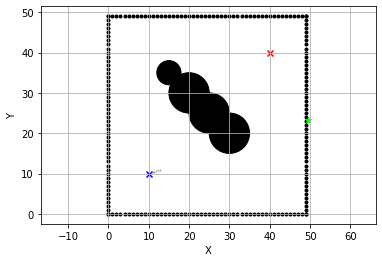

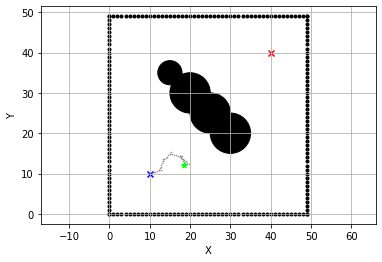

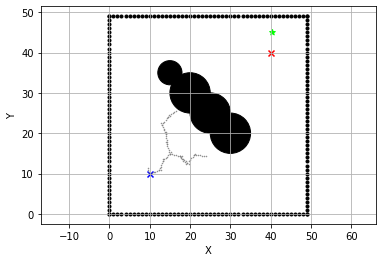

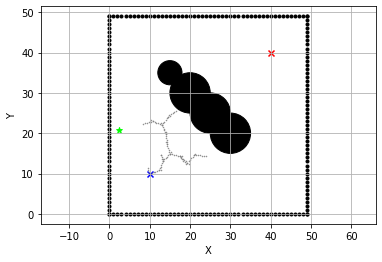

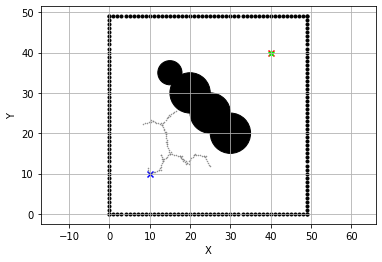

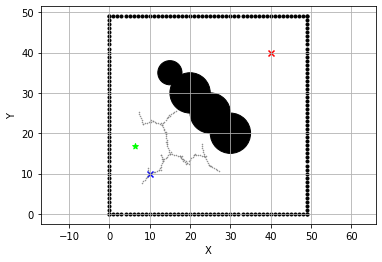

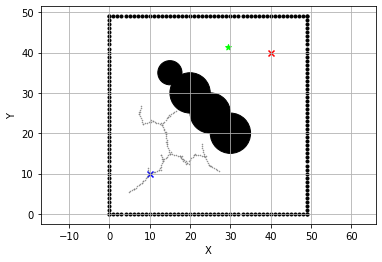

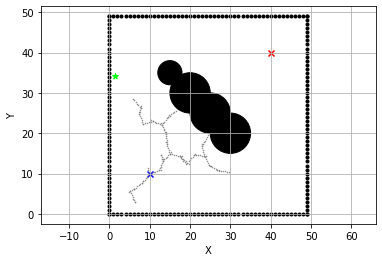

iteration = 72 : Rewire node 7 

iteration = 80 : Rewire node 15 



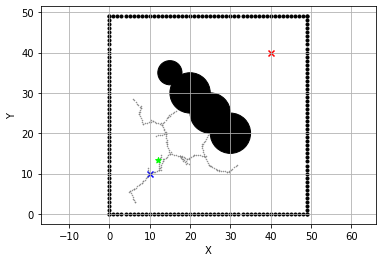

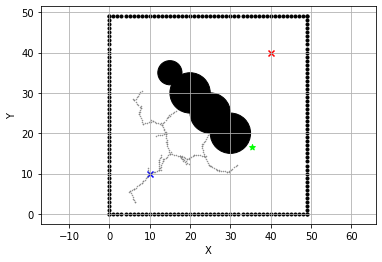

iteration = 95 : Rewire node 15 

iteration = 95 : Rewire node 33 



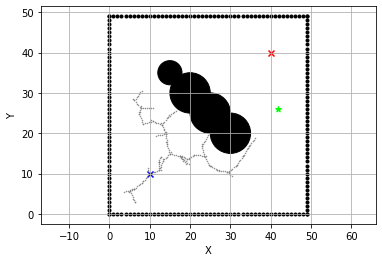

iteration = 102 : Rewire node 19 

iteration = 110 : Rewire node 12 

iteration = 110 : Rewire node 16 



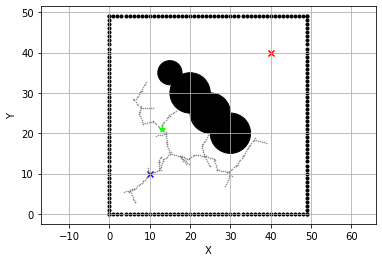

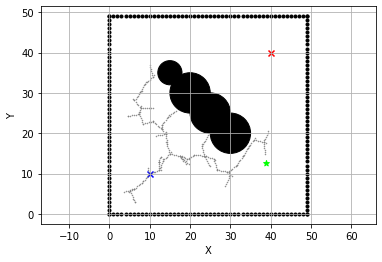

iteration = 123 : Rewire node 3 



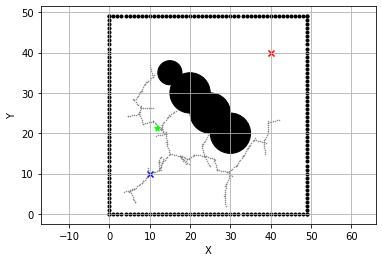

iteration = 139 : Rewire node 36 

iteration = 139 : Rewire node 62 



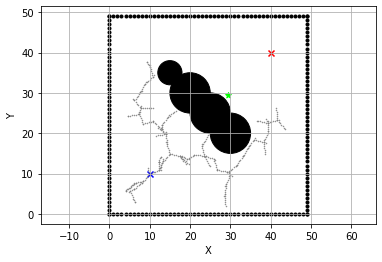

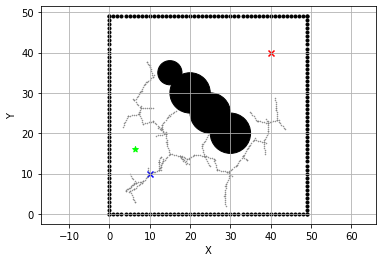

iteration = 151 : Rewire node 42 



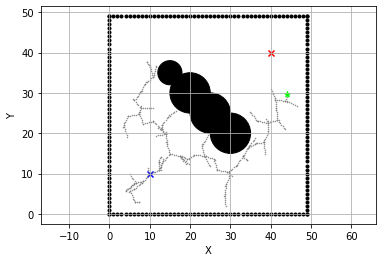

iteration = 164 : Rewire node 60 



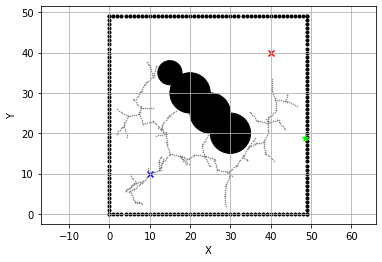

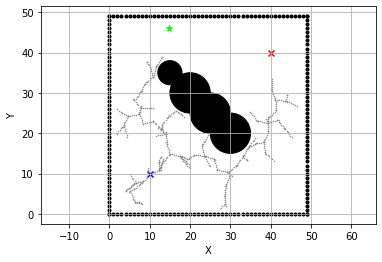

iteration = 187 : Rewire node 4 

iteration = 189 : Rewire node 5 

iteration = 189 : Rewire node 6 

iteration = 189 : Rewire node 7 

iteration = 189 : Rewire node 30 

iteration = 190 : Rewire node 17 

iteration = 190 : Rewire node 22 



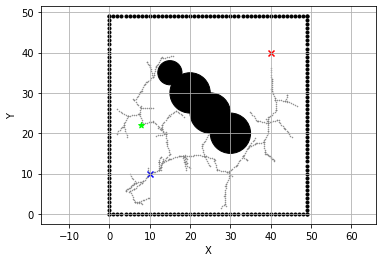

iteration = 199 : Rewire node 9 

iteration = 199 : Rewire node 10 



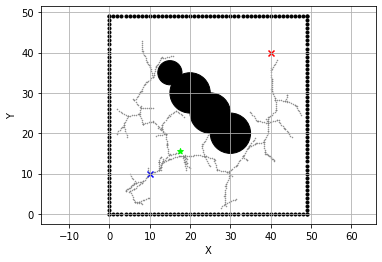

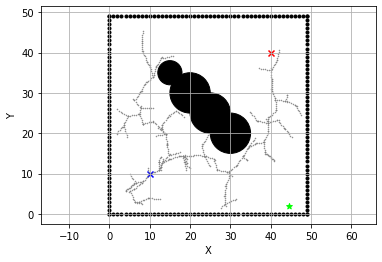

iteration = 216 : Rewire node 22 

iteration = 216 : Rewire node 24 

iteration = 216 : Rewire node 35 

iteration = 217 : Rewire node 20 

iteration = 217 : Rewire node 23 

iteration = 217 : Rewire node 64 

iteration = 219 : Rewire node 108 



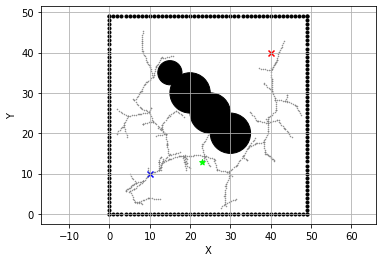

iteration = 224 : Rewire node 87 

iteration = 230 : Rewire node 2 

iteration = 230 : Rewire node 53 

iteration = 230 : Rewire node 89 



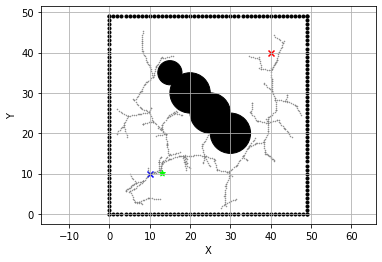

iteration = 232 : Rewire node 29 

iteration = 232 : Rewire node 48 

iteration = 233 : Rewire node 86 

iteration = 233 : Rewire node 114 

iteration = 240 : Rewire node 102 

iteration = 240 : Rewire node 113 



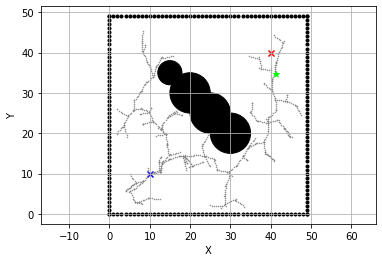

iteration = 249 : Rewire node 12 

iteration = 249 : Rewire node 31 

iteration = 249 : Rewire node 46 

iteration = 249 : Rewire node 57 



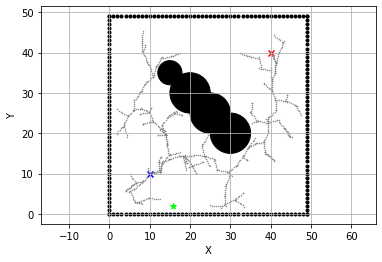

iteration = 255 : Rewire node 86 

iteration = 255 : Rewire node 95 

iteration = 256 : Rewire node 29 

iteration = 259 : Rewire node 114 



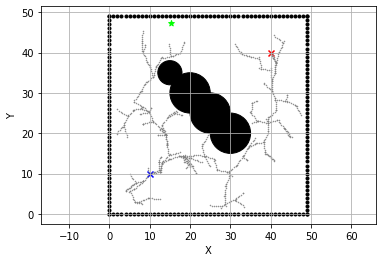

iteration = 266 : Rewire node 128 

iteration = 266 : Rewire node 130 

iteration = 268 : Rewire node 51 



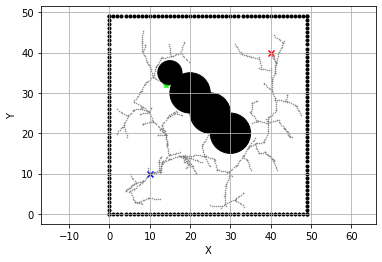

iteration = 273 : Rewire node 18 

iteration = 274 : Rewire node 2 

iteration = 274 : Rewire node 15 

iteration = 274 : Rewire node 33 

iteration = 274 : Rewire node 39 

iteration = 274 : Rewire node 53 

iteration = 274 : Rewire node 89 



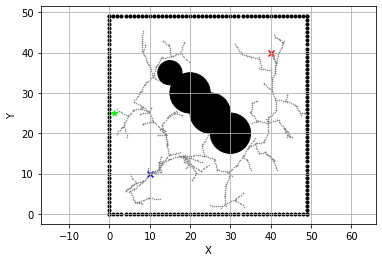

iteration = 285 : Rewire node 108 

iteration = 285 : Rewire node 128 

iteration = 285 : Rewire node 130 

iteration = 285 : Rewire node 141 

iteration = 285 : Rewire node 147 

iteration = 286 : Rewire node 18 

iteration = 286 : Rewire node 19 

iteration = 287 : Rewire node 101 

iteration = 287 : Rewire node 126 

iteration = 289 : Rewire node 66 



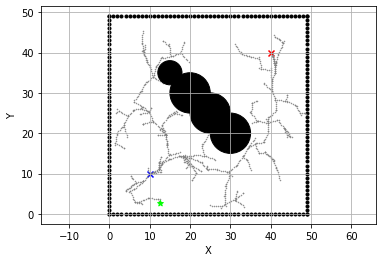

iteration = 295 : Rewire node 68 

iteration = 299 : Rewire node 105 

iteration = 299 : Rewire node 166 

----------------------------------------------------------------------------------
Reached max iteration !!!
len(nodes) = 174


In [ ]:
expand_dist = 3.0 # [m]
path_resolution = 0.5 # [m/step]
goal_sampling_rate = 5 # [%]
max_iteration = 300 # [回]

### ここがRRTとRRT*の違い 
connect_dist = 30.0 # [m]

start_node = Node(start_x, start_y)
goal_node = Node(goal_x, goal_y)

nodes = [start_node]

draw_iteration = 10
for iteration in range(max_iteration):
    ### フィールド内のランダムな座標にノードを一旦置く
    ### ただし100回の内 goal_sampling_rate 回はランダムな座標ではなくゴール座標を指定する
    ### こうすることで完全なランダムで乱れ打ちするより早めにゴールに到達しやすくなる
    if random.randint(0, 100) <= goal_sampling_rate:
        rand_node = Node(goal_x, goal_y)
    else:
        rand_node = Node(random.uniform(0.0, max_x), random.uniform(0.0, max_y))

    ### ランダムノードに最も近いノードからランダムノード方面に直線上に一定の距離だけ経路を伸ばしていく
    ### 一旦ここでは最近傍ノード (nearest_node) が注目ノード (new_node) の親ノードということにしとく
    nearest_node = FindNearestNode(nodes, rand_node)
    new_node = ExpandNode(expand_dist, path_resolution, from_node=nearest_node, to_node=rand_node)

    ### ここがRRTとRRT*の違い 
    near_nodes = FindNearNodes(connect_dist, expand_dist, nodes, new_node)
    if CheckCollision(new_node, obs_circles) and len(near_nodes) != 0:
        ### 近傍ノード達 (near_nodes) の中から → 注目ノード (new_node) までのコストが最小の近傍ノードを選ぶ
        min_near2new_cost = sys.float_info.max
        min_cost_near_node = None
        for near_node in near_nodes:
            near2new_node = ExpandNode(expand_dist, path_resolution, from_node=near_node, to_node=new_node)
            near2new_cost = CalcCost(from_node=near_node, to_node=new_node)
            if CheckCollision(near2new_node, obs_circles) and near2new_cost < min_near2new_cost:
                min_near2new_cost = near2new_cost
                min_cost_near_node = near_node
        
        ### コスト最小の近傍ノード (min_cost_near_node) を注目ノード (new_node) の新たな親ノードに変更してから，ノードリストに保存
        new_node = ExpandNode(expand_dist, path_resolution, from_node=min_cost_near_node, to_node=new_node)
        new_node.cost = min_near2new_cost
        nodes.append(new_node)

        ### [Rewire]
        ### 今度は逆に注目ノード (new_node) から → 近傍ノード達 (near_nodes) までのコスト調べて，
        ### コストが下回るなら注目ノード (new_node) を近傍ノード達 (near_nodes) の新たな親ノードに組み換える
        for near_node in near_nodes:
            new2near_node = ExpandNode(expand_dist, path_resolution, from_node=new_node, to_node=near_node)
            new2near_node.cost = CalcCost(from_node=new_node, to_node=near_node)
            if CheckCollision(new2near_node, obs_circles) and new2near_node.cost < near_node.cost:
                near_node_idx = FindNodeIndex(nodes, near_node)
                print('iteration =', iteration, ': Rewire node', near_node_idx, '\n')
                nodes[near_node_idx] = new2near_node
                PropagateCostToChildeNodes(nodes, new_node)

    ### 繰り返し数が draw_itr 回ごとに探索の途中経過を描画
    if iteration % draw_iteration == 0:
        DrawObsCircles(obs_circles)
        DrawField(wall_xs, wall_ys, start_x, start_y, goal_x, goal_y)
        DrawNodes(nodes, rand_node)
        plt.pause(0.001)
### End of for

print('----------------------------------------------------------------------------------')
print('Reached max iteration !!!')
print('len(nodes) =', len(nodes))

safe_final_node_idx = 102 , safe_final_node.cost = 70.6
safe_final_node_idx = 108 , safe_final_node.cost = 72.6
safe_final_node_idx = 113 , safe_final_node.cost = 70.6
safe_final_node_idx = 128 , safe_final_node.cost = 72.6
safe_final_node_idx = 128 , safe_final_node.cost = 72.6
safe_final_node_idx = 141 , safe_final_node.cost = 72.1
safe_final_node_idx = 128 , safe_final_node.cost = 72.6
safe_final_node_idx = 168 , safe_final_node.cost = 73.1
safe_final_node_idx = 170 , safe_final_node.cost = 73.1
----------------------------------------------------------------------------------
best_final_node_idx = 102 , best_final_node.cost = 70.6



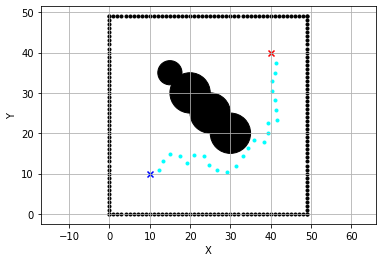

In [ ]:
### 探索した最終経路の始まりはゴール位置から
final_path_xs = [goal_x]
final_path_ys = [goal_y]

### ゴールに十分近く,かつ障害物に衝突しないノードをゴール到着ノードとする
safe_final_nodes = []
for node in nodes:
    dist_to_goal = math.sqrt((node.x - goal_node.x)**2 + (node.y - goal_node.y)**2) # [m]
    final_node = ExpandNode(expand_dist, path_resolution, from_node=node, to_node=goal_node)
    if dist_to_goal <= expand_dist and CheckCollision(final_node, obs_circles):
        safe_final_nodes.append(node)

if len(safe_final_nodes) == 0:
    print('Unfortunately, the path could not be found... \n')
else:
    ### ゴール到着ノード達の中から最適な（コストが最小な）ゴール到着ノードを選ぶ
    min_cost = sys.float_info.max
    best_final_node = None
    best_final_node_idx = None
    for safe_final_node in safe_final_nodes:
        safe_final_node_idx = FindNodeIndex(nodes, safe_final_node)
        print('safe_final_node_idx =', safe_final_node_idx, ', safe_final_node.cost =', round(safe_final_node.cost, 1))
        if safe_final_node.cost < min_cost:
            min_cost = safe_final_node.cost
            best_final_node = safe_final_node
            best_final_node_idx = safe_final_node_idx
    
    print('----------------------------------------------------------------------------------')
    print('best_final_node_idx =', best_final_node_idx, ', best_final_node.cost =', round(best_final_node.cost, 1))
    print()

    ### 最適なゴール到着ノードから親ノードIDを辿ってスタートノードに辿り着くまで（つまり node.parent_node が None になるまで）繰り返し
    node = best_final_node
    while node.parent_node is not None:
        final_path_xs.append(node.x)
        final_path_ys.append(node.y)
        node = node.parent_node
    
    ### スタート位置も最終経路に追加
    final_path_xs.append(start_x)
    final_path_ys.append(start_y)
    
    ### 探索した最終経路とフィールドを描画
    DrawObsCircles(obs_circles)
    plt.scatter(final_path_xs, final_path_ys, marker='.', color='cyan')
    DrawField(wall_xs, wall_ys, start_x, start_y, goal_x, goal_y)